In [5]:
import json 

def load_questions(activation_f, question_f, max_size = -1):
    activations_file = "/Users/daniel/ideaProjects/allennlp_invariances/" + activation_f
    questions_file = "/Users/daniel/ideaProjects/allennlp_invariances/" + question_f
    features = []
    pred_ans = []
    with open(activations_file) as f:
        content = f.read().splitlines()
        for i, l in enumerate(content):
            # print(i)
            # print(l[0:100])

            if (max_size > -1 and len(pred_ans) > max_size):
                break

            if i % 2 == 0:
                # print(l)
                data = json.loads(l)
                features.append(data)
            else:
                pred_ans.append(l)
    
    mat = numpy.array(features)
    print("features: " + str(len(features)))
    print("mat: " + str(len(mat)))
    print("pred_ans: " + str(len(pred_ans)))
    print("content: " + str(len(content)))
            
    questions = []
    labels = []
    with open(questions_file) as f:
        content = f.read().splitlines()
        for i, l in enumerate(content):
#             print(i)
#             print(l[0:100])
            if i % 3 == 0:
                questions.append({})
                questions[int(i / 3)]["p"] = l
            elif i % 3 == 1:
                questions[int(i / 3)]["q"] = l
            elif i % 3 == 2:
                ans = json.loads(l)
                questions[int(i / 3)]["a"] = [c['text'] for c in ans]
                labels.append(ans[0]['text'])

            if (max_size > -1 and len(labels) > max_size):
                break

    return (mat, labels, questions, pred_ans)

In [41]:
import json
import numpy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

(mat, labels, questions, pred_ans) = load_questions("ipython/bert/bert33.txt", "ipython/bert/bert22.txt", max_size=-1)

features: 10570
mat: 10570
pred_ans: 10570
content: 21140


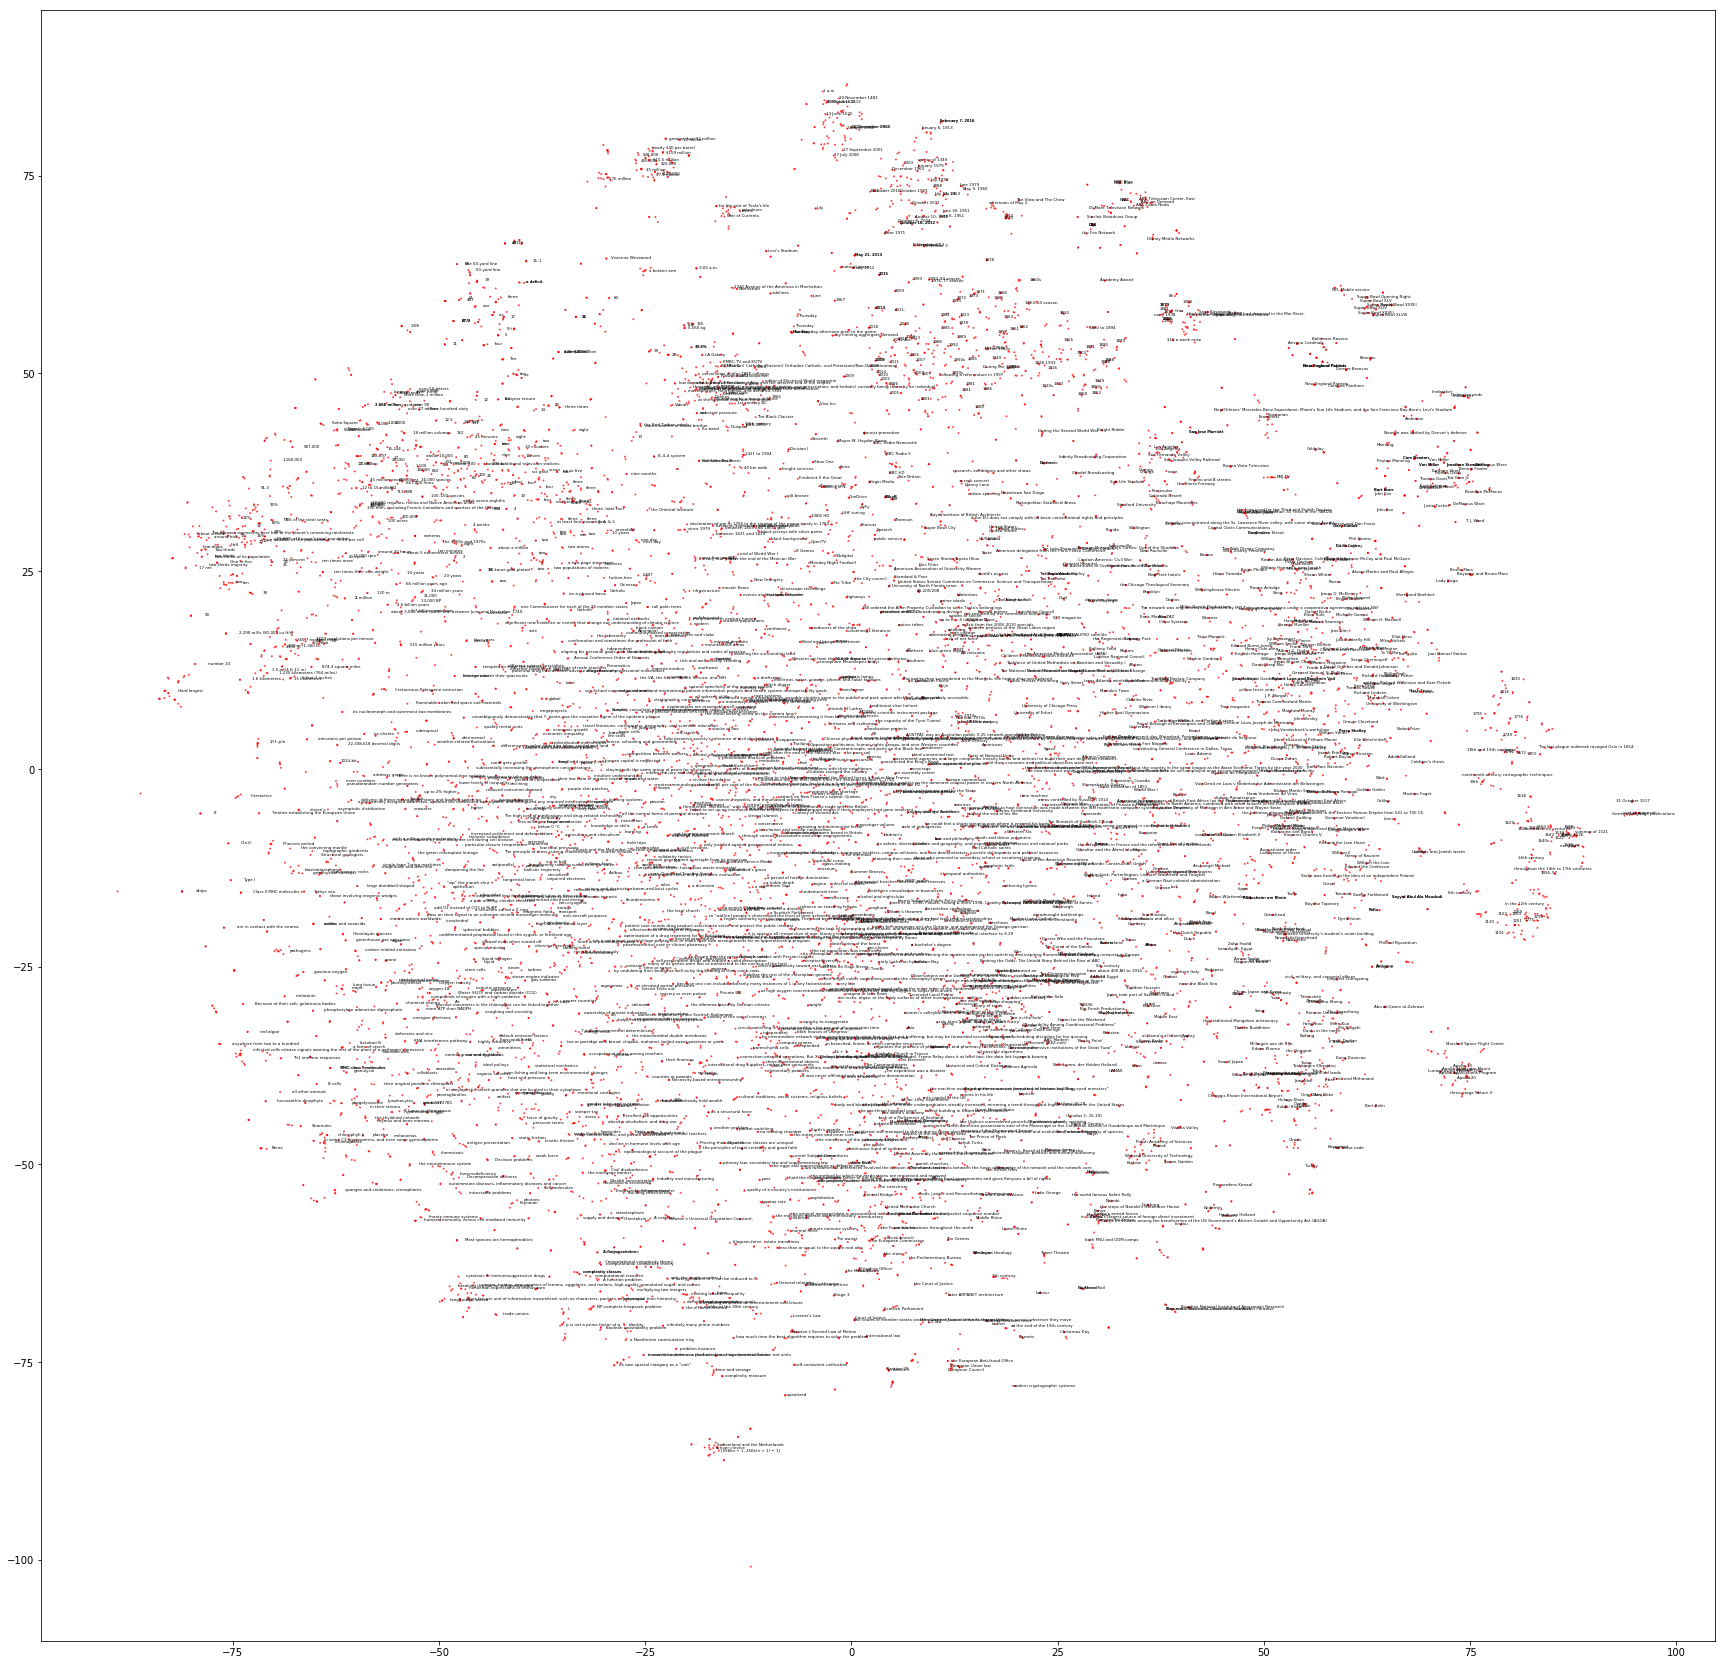

In [42]:
color = ['red' for l in labels]
X_embedded = TSNE(n_components=2,init="pca").fit_transform(mat)
fig, ax = plt.subplots()
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], color=color, alpha=0.6, s=1.1)
for i, txt in enumerate(labels):
    if i % 5 < 1:
        ax.annotate(txt, (X_embedded[i, 0] * 0.98, X_embedded[i, 1]), fontsize=4)
plt.savefig('/Users/daniel/ideaProjects/allennlp_invariances/ipython/bert/bert_on_squad.pdf', dpi = 100)

In [9]:
from prereq import Prerequisit_Skills

preq = Prerequisit_Skills()
# print(preq.skills_map)
prerequisits = preq.read_prereq_file("squad.json")

# ignore the nonsense content 
prerequisits = {x: prerequisits[x]  for x in prerequisits.keys() if 'Nonsense' not in prerequisits[x] }
print(len(prerequisits))
# print(set(prerequisits.keys()))
# print(len(set(prerequisits.keys())))
# prerequisits, len(prerequisits)

96


In [10]:
# extrat dev questions based on prerequesti keys 
question_paragraph_id_map = {}

paragraphs = []
dataset_file = "/Users/daniel/ideaProjects/linear-classifier/other/questionSets/squad-dev-v1.1.json"
with open(dataset_file) as file:
    dataset_json = json.load(file)
    dataset = dataset_json['data']
    for aid, article in enumerate(dataset):
        for pid, paragraph in enumerate(article['paragraphs']):
            context = paragraph['context']
            qas = []
            for qa in paragraph['qas']:
                qid = qa["id"] + "-1"
                if qid in prerequisits: 
                    qas.append(qa)
            if len(qas) > 0: 
                paragraphs.append({"context": context, "qas": qas})

data_json = {"data": [{"paragraphs": paragraphs}]}
with open('/Users/daniel/ideaProjects/allennlp_invariances/QA_datasets/squad-dev-v1.1-with-prereq-annotations.json', 'w', newline='') as f:
    f.write(json.dumps(data_json))

In [11]:
# read the questions and remember question ids:
question_paragraph_id_map = {}

dataset_file = "/Users/daniel/ideaProjects/allennlp_invariances/QA_datasets/squad-dev-v1.1-with-prereq-annotations.json"
with open(dataset_file) as file:
    dataset_json = json.load(file)
    dataset = dataset_json['data']
    for aid, article in enumerate(dataset):
        new_paragraphs = []
        for pid, paragraph in enumerate(article['paragraphs']):
            context = paragraph['context']
            for qa in paragraph['qas']:
                qid = qa["id"] + "-1"
                if qid in prerequisits: 
                    key = qa['question']
                    question_paragraph_id_map[key] = qid
len(question_paragraph_id_map)

96

In [12]:
import json
import numpy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

(mat, labels, questions, pred_ans) = load_questions("ipython/squad_dev_with_prereq_bert/bert33.txt", "ipython/squad_dev_with_prereq_bert/bert22.txt", max_size=-1)
# (mat_ad, labels_ad, questions_ad, pred_ans_ad) = load_questions("ipython/babi/out33-adv.txt", "ipython/babi/out22-adv.txt", max_size=-1)


features: 96
mat: 96
pred_ans: 96
content: 192


In [52]:
print(len(question_paragraph_id_map))
print(len(mat))
assert len(mat) == len(question_paragraph_id_map)

96
96


In [53]:
questions

[{'p': "The 8- and 10-county definitions are not used for the greater Southern California Megaregion, one of the 11 megaregions of the United States. The megaregion's area is more expansive, extending east into Las Vegas, Nevada, and south across the Mexican border into Tijuana.",
  'q': 'Which border does the megaregion extend over?',
  'a': ['Mexican', 'Mexican', 'Mexican']},
 {'p': "Within southern California are two major cities, Los Angeles and San Diego, as well as three of the country's largest metropolitan areas. With a population of 3,792,621, Los Angeles is the most populous city in California and the second most populous in the United States. To the south and with a population of 1,307,402 is San Diego, the second most populous city in the state and the eighth most populous in the nation.",
  'q': 'Which city is the most populous in California?',
  'a': ['Los Angeles', 'Los Angeles', 'Los Angeles']},
 {'p': '"Southern California" is not a formal geographic designation, and d

In [13]:
multirc_reasoning_types = []
for i, x in enumerate(questions): 
    key = x['q']
#     print(key)
    idd = question_paragraph_id_map[key]
    multirc_reasoning_types.append(prerequisits[idd])

bibi_reasoning_types = multirc_reasoning_types
    
len(multirc_reasoning_types), len(questions)

(96, 96)

In [14]:
from evaluate11 import metric_max_over_ground_truths, f1_score, exact_match_score

# find the quality per reasoning type
scores = []
unique_types111 = set([y for x in multirc_reasoning_types for y in x])
# print(unique_types111)

assert len(pred_ans) == len(questions)

scores_zipped_labels= []
for t in unique_types111:
    scores_ins = []
    # select questions which contain the reasoning type 
    for i, x  in enumerate(questions): 
        question = x["q"]
#         print(i)
#         (ans_text, correct_or_not, phenomenon_labels) = info_map[question]
#         assert sum(correct_or_not) > 0
        if t in multirc_reasoning_types[i]: # check if the target phenomena is included 
            correct_ans = x["a"]
            predicted_label = pred_ans[i]
            max_f1 = max([f1_score(predicted_label,y) for y in correct_ans])
            scores_ins.append(100.0 * max_f1)
    scores_zipped_labels.append((sum(scores_ins) / len(scores_ins), t))
    print(str(t) + " -> " + str(sum(scores_ins) / len(scores_ins)), len(scores))

# scores_zipped_labels

# unique_types111, multirc_reasoning_types

Elaboration -> 82.05128205128204 0
Schematic clauses -> 89.56590999601751 0
Bridging -> 89.74186055224607 0
No skill -> 96.02586713697825 0
Ellipsis (implicit info) -> 83.87096774193549 0
Punctuation -> 87.02664796633941 0
Coreference -> 83.33333333333333 0
Object  Tracking -> 66.66666666666667 0
Spatio-temporal -> 100.0 0


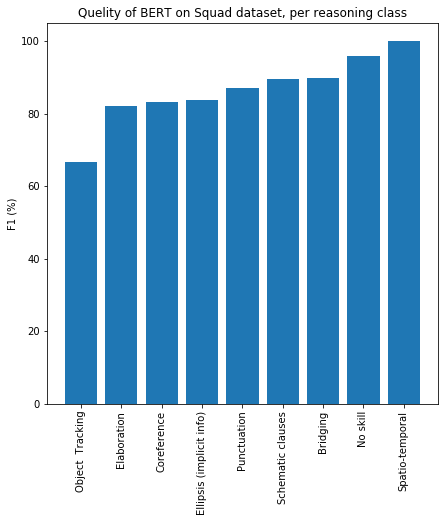

In [42]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['axes.unicode_minus'] = False
fig, ax = plt.subplots(figsize=(7, 7))

# scores_zipped_labels = list(zip(scores,unique_types111))
scores_zipped_labels.sort(key=lambda x: x[0])
scores22, unique_types22 = zip(*scores_zipped_labels)

plt.bar(range(len(scores22)), scores22)
# ax.plot(range(len(scores)), scores, 'o')
ax.set_ylabel('F1 (%)')
ax.set_title('Quelity of BERT on Squad dataset, per reasoning class')
# ax.set_yticks(range(len(q_labels)))
# ax.set_xticks(range(len(bibi_reasoning_types)))
ax.set_xticks(np.arange(len(unique_types22)))

# ax.set_yticklabels(q_labels)
ax.set_xticklabels(unique_types22, rotation=90)
plt.show()

In [9]:
# clustering points into two groups 
# (mat_ad, labels_ad, questions_ad, pred_ans_ad) = load_questions("ipython/squad_dev_with_prereq/out33-adv.txt", "ipython/squad_dev_with_prereq/out22-adv.txt", max_size=-1)

# # read the questions and remember question ids:
# question_paragraph_id_map = {}
# ff = "/Users/daniel/ideaProjects/allennlp/QA_datasets/babi-test.json"
# with open(ff) as file:
#     dataset_json = json.load(file)
#     dataset = dataset_json['data']
#     for article in dataset:
#         for paragraph in article['paragraphs']:
#             for qa in paragraph['qas']:
#                 key = qa['question'] + paragraph['context']
#                 question_paragraph_id_map[key] = qa['id']

# bibi_reasoning_types = [question_paragraph_id_map[x["q"]+x["p"]] for x in questions_ad]
# bibi_reasoning_types

In [16]:
unique_reasoning_types = list(set([y for x in bibi_reasoning_types for y in x]))

In [17]:
import numpy 

# bibi_reasoning_type_indices = [unique_reasoning_types.index(x) for x in bibi_reasoning_types]

ss = len(unique_reasoning_types)
accuracy_table = np.zeros(shape=(ss, ss)) 
count_table = np.empty(shape=(ss, ss), dtype=object) 

for ind1, type1 in enumerate(unique_reasoning_types): 
    for ind2, type2 in enumerate(unique_reasoning_types):
        
#         if ind1 > 3 or ind2 >3: 
#             continue 
        
        count1 = 0
        count2 = 0
    
        # we want different types 
        if type1 == type2 or ind2 <= ind1: 
            continue 
        print("type1: ", type1, " type2: ", type2)
        
        # loop through instances and select the points that have one of the two labels. 
        points = []
        labels = []
        for i, x in enumerate(bibi_reasoning_types): 
#             if type1 in x or type2 in x:
#                 points.append(mat[i])
#                 labels.append(x)
            
            if type1 in x and type2 not in x: 
                points.append(mat[i])
                labels.append(x)
                count1 += 1

            if type2 in x and type1 not in x : 
                points.append(mat[i])
                labels.append(x)
                count2 += 1
        
        from sklearn.cluster import KMeans
        print("len(points): ", len(points))
        # print("points: ", points)
        db = KMeans(n_clusters=2, random_state=2).fit(points)
        cluster_labels = db.labels_
        
        # calculate the confusion matrix 
        same_label_same_cluster = 0
        same_label_diff_cluster = 0
        diff_label_same_cluster = 0
        diff_label_diff_cluster = 0
        
        for ii in range(len(cluster_labels)):
            for jj in range(len(cluster_labels)):
                if ii == jj: 
                    continue 
                if cluster_labels[ii] == cluster_labels[jj] and labels[ii] == labels[jj]: 
                    same_label_same_cluster += 1
                if cluster_labels[ii] != cluster_labels[jj] and labels[ii] == labels[jj]: 
                    same_label_diff_cluster += 1
                if cluster_labels[ii] == cluster_labels[jj] and labels[ii] != labels[jj]: 
                    diff_label_same_cluster += 1
                if cluster_labels[ii] != cluster_labels[jj] and labels[ii] != labels[jj]: 
                    diff_label_diff_cluster += 1
        total_pairs = same_label_same_cluster + same_label_diff_cluster + diff_label_same_cluster + diff_label_diff_cluster
        print("same_label_same_cluster: ", same_label_same_cluster / total_pairs, same_label_same_cluster)
        print("same_label_diff_cluster: ", same_label_diff_cluster / total_pairs, same_label_diff_cluster)
        print("diff_label_same_cluster: ", diff_label_same_cluster / total_pairs, diff_label_same_cluster)
        print("diff_label_diff_cluster: ", diff_label_diff_cluster / total_pairs, diff_label_diff_cluster)
        print("---------")
        accuracy_table[ind1][ind2] = (diff_label_diff_cluster + same_label_same_cluster) / total_pairs
        accuracy_table[ind2][ind1] = accuracy_table[ind1][ind2] 
        
        countstr = str(f"{len(labels)}/{count1}/{count2}")
        print(countstr)
        count_table[ind1][ind2] = countstr
        count_table[ind2][ind1] = count_table[ind1][ind2] 
        
accuracy_table

type1:  Elaboration  type2:  Schematic clauses
len(points):  32
same_label_same_cluster:  0.08870967741935484 88
same_label_diff_cluster:  0.006048387096774193 6
diff_label_same_cluster:  0.7358870967741935 730
diff_label_diff_cluster:  0.1693548387096774 168
---------
32/9/23
type1:  Elaboration  type2:  Bridging
len(points):  46
same_label_same_cluster:  0.07053140096618357 146
same_label_diff_cluster:  0.08019323671497584 166
diff_label_same_cluster:  0.4222222222222222 874
diff_label_diff_cluster:  0.4270531400966184 884
---------
46/9/37
type1:  Elaboration  type2:  No skill
len(points):  40
same_label_same_cluster:  0.2512820512820513 392
same_label_diff_cluster:  0.2141025641025641 334
diff_label_same_cluster:  0.2564102564102564 400
diff_label_diff_cluster:  0.2782051282051282 434
---------
40/13/27
type1:  Elaboration  type2:  Ellipsis (implicit info)
len(points):  16
same_label_same_cluster:  0.058333333333333334 14
same_label_diff_cluster:  0.041666666666666664 10
diff_label

same_label_same_cluster:  0.10666666666666667 64
same_label_diff_cluster:  0.03666666666666667 22
diff_label_same_cluster:  0.6133333333333333 368
diff_label_diff_cluster:  0.24333333333333335 146
---------
25/23/2
type1:  Coreference  type2:  Object  Tracking
len(points):  13
same_label_same_cluster:  0.08974358974358974 14
same_label_diff_cluster:  0.0 0
diff_label_same_cluster:  0.7564102564102564 118
diff_label_diff_cluster:  0.15384615384615385 24
---------
13/11/2
type1:  Coreference  type2:  Spatio-temporal
len(points):  14
same_label_same_cluster:  0.04395604395604396 8
same_label_diff_cluster:  0.03296703296703297 6
diff_label_same_cluster:  0.5934065934065934 108
diff_label_diff_cluster:  0.32967032967032966 60
---------
14/12/2
type1:  Object  Tracking  type2:  Spatio-temporal
len(points):  5
same_label_same_cluster:  0.0 0
same_label_diff_cluster:  0.0 0
diff_label_same_cluster:  0.6 12
diff_label_diff_cluster:  0.4 8
---------
5/3/2


array([[0.        , 0.25806452, 0.49758454, 0.52948718, 0.25      ,
        0.43548387, 0.40441176, 0.48351648, 0.45714286],
       [0.25806452, 0.        , 0.32270531, 0.44374563, 0.30461538,
        0.50201613, 0.27920228, 0.24615385, 0.33903134],
       [0.49758454, 0.32270531, 0.        , 0.48156277, 0.49358974,
        0.32620321, 0.45210084, 0.35888502, 0.23698782],
       [0.52948718, 0.44374563, 0.48156277, 0.        , 0.63218391,
        0.49714286, 0.46423752, 0.71494253, 0.53448276],
       [0.25      , 0.30461538, 0.49358974, 0.63218391, 0.        ,
        0.33538462, 0.31428571, 0.33333333, 0.6       ],
       [0.43548387, 0.50201613, 0.32620321, 0.49714286, 0.33538462,
        0.        , 0.42687747, 0.41125541, 0.35      ],
       [0.40441176, 0.27920228, 0.45210084, 0.46423752, 0.31428571,
        0.42687747, 0.        , 0.24358974, 0.37362637],
       [0.48351648, 0.24615385, 0.35888502, 0.71494253, 0.33333333,
        0.41125541, 0.24358974, 0.        , 0.4       ],


/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


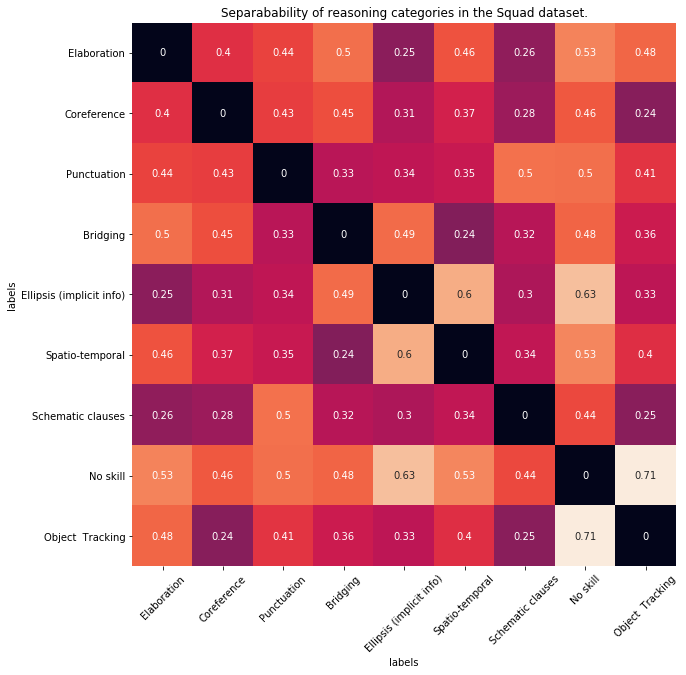

In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import cluster, metrics

plt.figure(figsize=(10, 10))
sss = sns.heatmap(accuracy_table, square=True,
            annot=True,
            cbar=False,
            xticklabels=True,
            yticklabels=True
            )

sss.set_xticklabels(unique_reasoning_types, rotation=45)
sss.set_yticklabels(unique_reasoning_types, rotation=0)
plt.xlabel('labels')
plt.ylabel('labels')
plt.title('Separabability of reasoning categories in the Squad dataset.')
plt.show()

In [18]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in accuracy_table]))

0.0	0.25806451612903225	0.4975845410628019	0.5294871794871795	0.25	0.43548387096774194	0.40441176470588236	0.4835164835164835	0.45714285714285713
0.25806451612903225	0.0	0.32270531400966185	0.4437456324248777	0.3046153846153846	0.5020161290322581	0.2792022792022792	0.24615384615384617	0.33903133903133903
0.4975845410628019	0.32270531400966185	0.0	0.4815627743634767	0.4935897435897436	0.32620320855614976	0.45210084033613446	0.3588850174216028	0.2369878183831672
0.5294871794871795	0.4437456324248777	0.4815627743634767	0.0	0.632183908045977	0.49714285714285716	0.4642375168690958	0.7149425287356321	0.5344827586206896
0.25	0.3046153846153846	0.4935897435897436	0.632183908045977	0.0	0.3353846153846154	0.3142857142857143	0.3333333333333333	0.6
0.43548387096774194	0.5020161290322581	0.32620320855614976	0.49714285714285716	0.3353846153846154	0.0	0.4268774703557312	0.41125541125541126	0.35
0.40441176470588236	0.2792022792022792	0.45210084033613446	0.4642375168690958	0.3142857142857143	0.42687747

In [19]:
count_table[count_table == None] = ""
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in count_table]))
unique_reasoning_types

	32/9/23	46/9/37	40/13/27	16/13/3	32/11/21	17/9/8	14/12/2	15/13/2
32/9/23		46/16/30	54/27/27	26/25/1	32/18/14	27/21/6	26/25/1	27/26/1
46/9/37	46/16/30		68/41/27	40/39/1	34/26/8	35/32/3	42/40/2	43/41/2
40/13/27	54/27/27	68/41/27		30/27/3	50/27/23	39/27/12	30/27/3	29/27/2
16/13/3	26/25/1	40/39/1	30/27/3		26/3/23	15/3/12	6/3/3	5/3/2
32/11/21	32/18/14	34/26/8	50/27/23	26/3/23		23/17/6	22/21/1	25/23/2
17/9/8	27/21/6	35/32/3	39/27/12	15/3/12	23/17/6		13/11/2	14/12/2
14/12/2	26/25/1	42/40/2	30/27/3	6/3/3	22/21/1	13/11/2		5/3/2
15/13/2	27/26/1	43/41/2	29/27/2	5/3/2	25/23/2	14/12/2	5/3/2	


['Elaboration',
 'Schematic clauses',
 'Bridging',
 'No skill',
 'Ellipsis (implicit info)',
 'Punctuation',
 'Coreference',
 'Object  Tracking',
 'Spatio-temporal']

In [20]:
from sklearn.cluster import SpectralClustering

# Cluster
cluster_size = 3
sc = SpectralClustering(cluster_size, affinity='precomputed')
sc.fit(accuracy_table > 0.9)
# cluster_labels = sc.labels_
# cluster_labels

# db = KMeans(n_clusters=cluster_size, random_state=2).fit(accuracy_table > 0.8)
# db = DBSCAN(eps=0.3, min_samples=10, affinity='precomputed').fit(accuracy_table > 0.9)
# core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True
cluster_labels = db.labels_

/Users/daniel/.virtualenvs/bidaf_allennlp/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Type Bridging in cluster 0 
Type Elaboration in cluster 1 
Type Schematic clauses in cluster 1 
Type No skill in cluster 1 
Type Ellipsis (implicit info) in cluster 1 


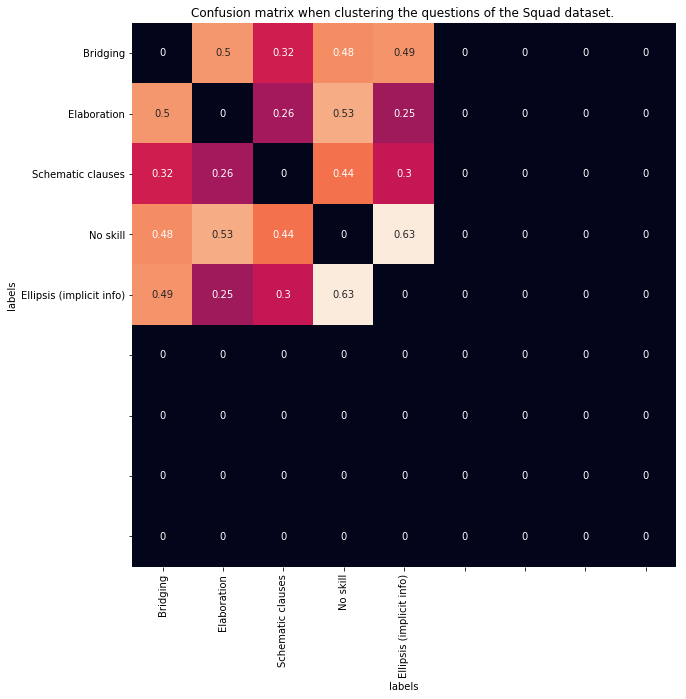

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import cluster, metrics

unique_reasoning_types_new_ordering = []
new_to_old_type_map = {}
for cluster_id in range(cluster_size): 
    for label_id in range(len(cluster_labels)): 
        if cluster_labels[label_id] == cluster_id: 
            print(f"Type {unique_reasoning_types[label_id]} in cluster {cluster_id} ")
            new_id = len(unique_reasoning_types_new_ordering)
            new_to_old_type_map[new_id] = label_id
            unique_reasoning_types_new_ordering.append(unique_reasoning_types[label_id])
            
unique_reasoning_types_new_ordering, new_to_old_type_map

accuracy_table_new = np.zeros(shape=(ss, ss)) 

for new_id1 in range(len(unique_reasoning_types_new_ordering)): 
    for new_id2 in range(len(unique_reasoning_types_new_ordering)):
        id1 = new_to_old_type_map[new_id1]
        id2 = new_to_old_type_map[new_id2]
        accuracy_table_new[new_id1][new_id2] = accuracy_table[id1][id2]
    
plt.figure(figsize=(10, 10))
sss = sns.heatmap(accuracy_table_new, square=True,
            annot=True,
            cbar=False,
            xticklabels=True,
            yticklabels=True)

sss.set_xticklabels(unique_reasoning_types_new_ordering, rotation=90)
sss.set_yticklabels(unique_reasoning_types_new_ordering, rotation=0)
plt.xlabel('labels')
plt.ylabel('labels')
plt.title('Confusion matrix when clustering the questions of the Squad dataset. ')
plt.show()

[[0.         0.51612903 0.99516908 1.05897436 0.5        0.87096774
  0.80882353 0.96703297 0.91428571]
 [0.51612903 0.         0.64541063 0.88749126 0.60923077 1.00403226
  0.55840456 0.49230769 0.67806268]
 [0.99516908 0.64541063 0.         0.96312555 0.98717949 0.65240642
  0.90420168 0.71777003 0.47397564]
 [1.05897436 0.88749126 0.96312555 0.         1.26436782 0.99428571
  0.92847503 1.37979896 1.06896552]
 [0.5        0.60923077 0.98717949 1.26436782 0.         0.67076923
  0.62857143 0.66666667 1.2       ]
 [0.87096774 1.00403226 0.65240642 0.99428571 0.67076923 0.
  0.85375494 0.82251082 0.7       ]
 [0.80882353 0.55840456 0.90420168 0.92847503 0.62857143 0.85375494
  0.         0.48717949 0.74725275]
 [0.96703297 0.49230769 0.71777003 1.37979896 0.66666667 0.82251082
  0.48717949 0.         0.8       ]
 [0.91428571 0.67806268 0.47397564 1.06896552 1.2        0.7
  0.74725275 0.8        0.        ]]


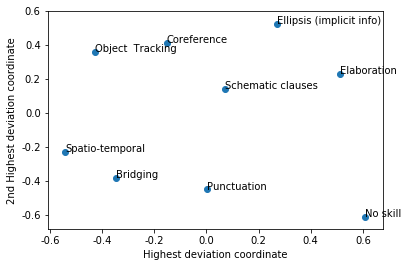

In [22]:
# Enforce triangle inequality
from scipy.sparse.csgraph import shortest_path

distanceMatrix = accuracy_table # - np.ones(distanceMatrix.shape)
pathDistance=shortest_path(2*distanceMatrix)
print(pathDistance)

from sklearn.manifold import MDS
import matplotlib.pyplot as plt
mds=MDS(n_components=2,dissimilarity="precomputed", random_state=4)
emb=mds.fit_transform(pathDistance)
fig, ax = plt.subplots()
ax.scatter(emb[:,0],emb[:,1])
ax.set_xlabel("Highest deviation coordinate")
ax.set_ylabel("2nd Highest deviation coordinate")
plt.title('Project of the separabability of reasoning classes onto a 2d plane. ')
for i, txt in enumerate(unique_reasoning_types):
    ax.annotate(txt, (emb[i,0],emb[i,1]))
plt.show()

In [23]:
# separate points with SVM : 
import numpy 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# unique_reasoning_types = list(set(bibi_reasoning_types))

# bibi_reasoning_type_indices = [unique_reasoning_types.index(x) for x in bibi_reasoning_types]

ss = len(unique_reasoning_types)
accuracy_table = np.zeros(shape=(ss, ss)) 

for ind1, type1 in enumerate(unique_reasoning_types): 
    for ind2, type2 in enumerate(unique_reasoning_types):
                
        # we want different types 
        if type1 == type2 or ind2 <= ind1: 
            continue 
        print("type1: ", type1, " type2: ", type2)
        
        # loop through instances and select the points that have one of the two labels. 
        points = []
        labels = []
        original_labels = []
                
        print("bibi_reasoning_types: ", len(bibi_reasoning_types))
        for i, x in enumerate(bibi_reasoning_types):                 
            if type1 in x or type2 in x:
                if type1 in x and type2 not in x: 
                    labels.append(1)
                    points.append(mat[i])
                    original_labels.append(x)
                    
                if type2 in x and type1 not in x : 
                    labels.append(0)
                    points.append(mat[i])
                    original_labels.append(x)
                
        assert len(points) < 100  
        
        if len(points) > 15: 
            # clf = SVC()
            clf = LogisticRegression(penalty='l1', C=0.6)
            print("points: ", len(points))
            print("labels: ", len(labels))
            clf.fit(points, labels) 
            print("labels: ", labels)
            cluster_labels = clf.predict(points)
            print("cluster_labels: ", len(cluster_labels))
            print(cluster_labels)

            # calculate the confusion matrix 
            same_label_same_cluster = 0
            same_label_diff_cluster = 0
            diff_label_same_cluster = 0
            diff_label_diff_cluster = 0

            def check_if_label_is_shared(labels1, labels2): 
                label_intersection = list(set(labels1) & set(labels2))
                return (type1 in label_intersection) or (type2 in label_intersection)

            for ii in range(len(cluster_labels)):
                for jj in range(len(cluster_labels)):
    #                 print(labels[ii], labels[jj], labels[ii] == labels[jj])
                    if ii == jj: 
                        continue 
                    if cluster_labels[ii] == cluster_labels[jj] and check_if_label_is_shared(original_labels[ii], original_labels[jj]): 
                        same_label_same_cluster += 1
                    if cluster_labels[ii] != cluster_labels[jj] and check_if_label_is_shared(original_labels[ii], original_labels[jj]): 
                        same_label_diff_cluster += 1
                    if cluster_labels[ii] == cluster_labels[jj] and not check_if_label_is_shared(original_labels[ii], original_labels[jj]): 
                        diff_label_same_cluster += 1
                    if cluster_labels[ii] != cluster_labels[jj] and not check_if_label_is_shared(original_labels[ii], original_labels[jj]): 
                        diff_label_diff_cluster += 1
            total_pairs = same_label_same_cluster + same_label_diff_cluster + diff_label_same_cluster + diff_label_diff_cluster
            print("same_label_same_cluster: ", same_label_same_cluster / total_pairs, same_label_same_cluster)
            print("same_label_diff_cluster: ", same_label_diff_cluster / total_pairs, same_label_diff_cluster)
            print("diff_label_same_cluster: ", diff_label_same_cluster / total_pairs, diff_label_same_cluster)
            print("diff_label_diff_cluster: ", diff_label_diff_cluster / total_pairs, diff_label_diff_cluster)
            print("---------")
            accuracy_table[ind1][ind2] = (diff_label_diff_cluster + same_label_same_cluster) / total_pairs
            accuracy_table[ind2][ind1] = accuracy_table[ind1][ind2] 
        else: 
            accuracy_table[ind2][ind1] = -1 
            accuracy_table[ind1][ind2] = -1
accuracy_table

type1:  Elaboration  type2:  Schematic clauses
bibi_reasoning_types:  96
points:  32
labels:  32
labels:  [0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]
cluster_labels:  32
[0 1 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
same_label_same_cluster:  0.5544354838709677 550
same_label_diff_cluster:  0.028225806451612902 28
diff_label_same_cluster:  0.09274193548387097 92
diff_label_diff_cluster:  0.3245967741935484 322
---------
type1:  Elaboration  type2:  Bridging
bibi_reasoning_types:  96
points:  46
labels:  46
labels:  [0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
cluster_labels:  46
[0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
same_label_same_cluster:  0.6647342995169082 1376
same_label_diff_cluster:  0.01352657004830918 28
diff_label_same_cluster:  0.07149758454106281 148
diff

array([[ 0.        ,  0.87903226,  0.91497585,  1.        ,  0.875     ,
         0.9375    ,  1.        , -1.        , -1.        ],
       [ 0.87903226,  0.        ,  1.        ,  1.        ,  0.92307692,
         1.        ,  0.79487179,  0.92307692,  0.92592593],
       [ 0.91497585,  1.        ,  0.        ,  1.        ,  0.95      ,
         0.94117647,  0.83865546,  0.90708479,  0.90919158],
       [ 1.        ,  1.        ,  1.        ,  0.        ,  0.8137931 ,
         1.        ,  1.        ,  0.87126437,  0.86699507],
       [ 0.875     ,  0.92307692,  0.95      ,  0.8137931 ,  0.        ,
         0.78769231, -1.        , -1.        , -1.        ],
       [ 0.9375    ,  1.        ,  0.94117647,  1.        ,  0.78769231,
         0.        ,  1.        ,  0.90909091,  0.84666667],
       [ 1.        ,  0.79487179,  0.83865546,  1.        , -1.        ,
         1.        ,  0.        , -1.        , -1.        ],
       [-1.        ,  0.92307692,  0.90708479,  0.87126437, -1

In [24]:
indices_to_keep = [idx for idx, val in enumerate(np.min(np.matrix(accuracy_table), axis=0).flat) if val != -1]


accuracy_table_small = accuracy_table[indices_to_keep][:,indices_to_keep]
unique_reasoning_types_small = np.array(unique_reasoning_types)[indices_to_keep]

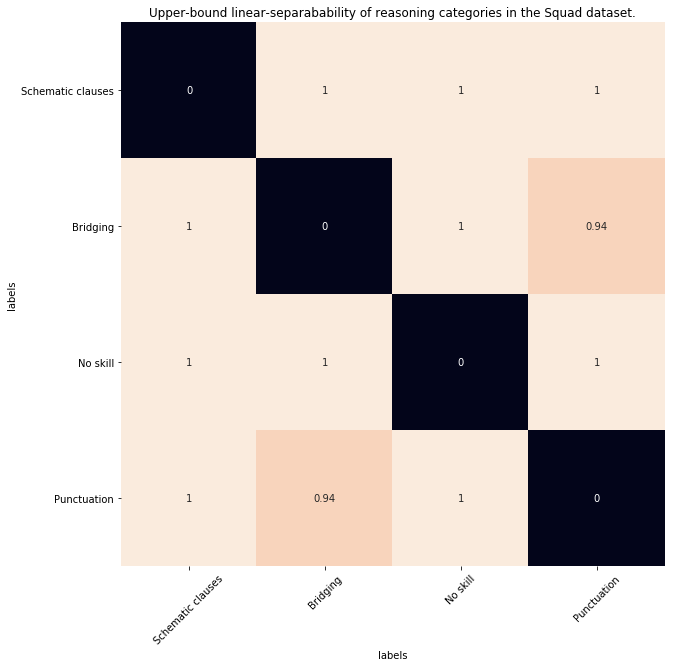

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import cluster, metrics

plt.figure(figsize=(10, 10))

sss = sns.heatmap(accuracy_table_small, square=True,
            annot=True,
            cbar=False,
            xticklabels=True,
            yticklabels=True
            )

sss.set_xticklabels(unique_reasoning_types_small, rotation=45)
sss.set_yticklabels(unique_reasoning_types_small, rotation=0)
plt.xlabel('labels')
plt.ylabel('labels')
plt.title('Upper-bound linear-separabability of reasoning categories in the Squad dataset.')
plt.show()

{'Bridging',
 'Coreference',
 'Elaboration',
 'Ellipsis (implicit info)',
 'No skill',
 'Object Tracking',
 'Punctuation',
 'Schematic clauses',
 'Spatio-temporal'}

In [33]:
# Enforce triangle inequality
from scipy.sparse.csgraph import shortest_path

distanceMatrix = accuracy_table # - np.ones(distanceMatrix.shape)
pathDistance=shortest_path(2*distanceMatrix)
print(pathDistance)

from sklearn.manifold import MDS
import matplotlib.pyplot as plt
mds=MDS(n_components=2,dissimilarity="precomputed", random_state=4)
emb=mds.fit_transform(pathDistance)
fig, ax = plt.subplots()
ax.scatter(emb[:,0],emb[:,1])
ax.set_xlabel("Highest deviation coordinate")
ax.set_ylabel("2nd Highest deviation coordinate")
for i, txt in enumerate(unique_reasoning_types):
    ax.annotate(txt, (emb[i,0],emb[i,1]))
plt.show()
unique_reasoning_types

[[ 0. inf inf inf inf inf inf inf inf]
 [inf  0. inf inf inf inf inf inf inf]
 [inf inf  0. inf inf inf inf inf inf]
 [inf inf inf  0. inf inf inf inf inf]
 [inf inf inf inf  0. inf inf inf inf]
 [inf inf inf inf inf  0. inf inf inf]
 [inf inf inf inf inf inf  0. inf inf]
 [inf inf inf inf inf inf inf  0. inf]
 [inf inf inf inf inf inf inf inf  0.]]


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [34]:
# a single classifier 
from sklearn.neural_network import MLPClassifier

# training a single classifier on the data 
from sklearn.linear_model import LogisticRegression
import numpy 

ss = len(unique_reasoning_types)
accuracy_table = np.zeros(shape=(ss, ss)) 


from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
multirc_reasoning_types_binarized = mlb.fit_transform(multirc_reasoning_types)
mlb.classes_

# print(len(multirc_reasoning_types))

mlp = MLPClassifier(hidden_layer_sizes=(), alpha=10)
mlp.fit(mat,multirc_reasoning_types_binarized)

/Users/daniel/.virtualenvs/bidaf_allennlp/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=10, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [35]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import f1_score    
    
predictions = mlp.predict(mat)

for i, class_ in enumerate(mlb.classes_): 
    predictions_per_class = [x[i] for x in predictions]
    gold_per_class = [x[i] for x in multirc_reasoning_types_binarized]
    f1_ = f1_score(gold_per_class, predictions_per_class) 
    size_ = sum(gold_per_class)
    print(f"Class: {class_} \t count: {size_} \t F1: {f1_}")

Class: Bridging 	 count: 41 	 F1: 1.0
Class: Coreference 	 count: 12 	 F1: 1.0
Class: Elaboration 	 count: 13 	 F1: 1.0
Class: Ellipsis (implicit info) 	 count: 3 	 F1: 1.0
Class: No skill 	 count: 27 	 F1: 1.0
Class: Object  Tracking 	 count: 3 	 F1: 1.0
Class: Punctuation 	 count: 23 	 F1: 1.0
Class: Schematic clauses 	 count: 27 	 F1: 1.0
Class: Spatio-temporal 	 count: 2 	 F1: 1.0


In [36]:
# train a single classifier, which gets two input vectors and tell us whether the they share a class or not. 
import random 

# first, create the input data. 
assert len(mat) == len(multirc_reasoning_types)

input_mat = []
output_vals = []

def are_disjoint(a, b): 
    return set(a).isdisjoint(b)

for i, x1 in enumerate(mat): 
    print(f"adding instances: {100.0 * i / len(mat)}")
    for j, x2 in enumerate(mat): 
        if i == j: 
            continue 
            
        if are_disjoint(multirc_reasoning_types[i], multirc_reasoning_types[j]): 
            output_vals.append(1)
            input_mat.append(mat[i] + mat[j])
        else:
            if random.uniform(0, 1) >= 0.75: 
                continue 
            input_mat.append(mat[i] + mat[j])
            output_vals.append(0)

adding instances: 0.0
adding instances: 1.0416666666666667
adding instances: 2.0833333333333335
adding instances: 3.125
adding instances: 4.166666666666667
adding instances: 5.208333333333333
adding instances: 6.25
adding instances: 7.291666666666667
adding instances: 8.333333333333334
adding instances: 9.375
adding instances: 10.416666666666666
adding instances: 11.458333333333334
adding instances: 12.5
adding instances: 13.541666666666666
adding instances: 14.583333333333334
adding instances: 15.625
adding instances: 16.666666666666668
adding instances: 17.708333333333332
adding instances: 18.75
adding instances: 19.791666666666668
adding instances: 20.833333333333332
adding instances: 21.875
adding instances: 22.916666666666668
adding instances: 23.958333333333332
adding instances: 25.0
adding instances: 26.041666666666668
adding instances: 27.083333333333332
adding instances: 28.125
adding instances: 29.166666666666668
adding instances: 30.208333333333332
adding instances: 31.25
ad

In [29]:
# make sure the dataset selection is balanced 
sum(output_vals), len(output_vals)

(5766, 8258)

In [37]:
# train the classifier 
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(input_mat, output_vals) 

sum(output_vals)

5766

In [38]:
ss = len(unique_types111)
separation_table = np.zeros(shape=(ss, ss)) 
unique_types111_list = list(unique_types111)
for ind1, type1 in enumerate(unique_types111_list): 
    for ind2, type2 in enumerate(unique_types111_list):
        
        # we want different types 
        if type1 == type2: #  or ind2 <= ind1  
            continue 
        print("type1: ", type1, " type2: ", type2)
        
        # loop through instances and select the points that have one of the two labels. 

        y_true = []
        input_vecs = []
        for i, x in enumerate(multirc_reasoning_types): 
            for j, y in enumerate(multirc_reasoning_types): 
                if type1 in x and type2 in y: 
                    input_vecs.append(mat[i] + mat[j]) 
                    if are_disjoint(x, y): 
                        y_true.append(1)
                    else: 
                        y_true.append(0)
                
        y_pred = list(clf.predict(input_vecs))
        
        assert(len(y_pred) == len(y_true))
#         print(y_pred)
#         print(y_true)
    
        from sklearn.metrics import f1_score
        separation_table[ind1][ind2] = f1_score(y_true, y_pred)
        print(separation_table[ind1][ind2])

type1:  Elaboration  type2:  Schematic clauses
0.8019559902200489
type1:  Elaboration  type2:  Bridging
0.9041095890410958
type1:  Elaboration  type2:  No skill
0.9646017699115045
type1:  Elaboration  type2:  Ellipsis (implicit info)
0.9199999999999999
type1:  Elaboration  type2:  Punctuation
0.8795518207282914
type1:  Elaboration  type2:  Coreference
0.6666666666666666
type1:  Elaboration  type2:  Object  Tracking
0.7906976744186047
type1:  Elaboration  type2:  Spatio-temporal
0.9361702127659575
type1:  Schematic clauses  type2:  Elaboration
0.8019559902200489
type1:  Schematic clauses  type2:  Bridging
0.8916201117318435
type1:  Schematic clauses  type2:  No skill
0.9600570613409415
type1:  Schematic clauses  type2:  Ellipsis (implicit info)
0.4516129032258065
type1:  Schematic clauses  type2:  Punctuation
0.7881355932203391
type1:  Schematic clauses  type2:  Coreference
0.7777777777777777
type1:  Schematic clauses  type2:  Object  Tracking
0.4
type1:  Schematic clauses  type2:  Spat

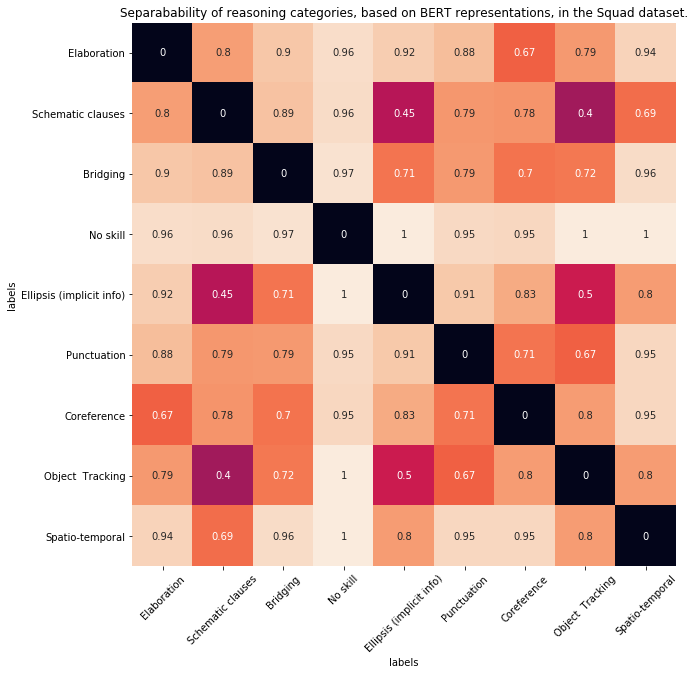

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import cluster, metrics

plt.figure(figsize=(10, 10))
sss = sns.heatmap(separation_table, square=True,
            annot=True,
            cbar=False,
            xticklabels=True,
            yticklabels=True
            )

sss.set_xticklabels(unique_types111_list, rotation=45)
sss.set_yticklabels(unique_types111_list, rotation=0)
plt.xlabel('labels')
plt.ylabel('labels')
plt.title('Separabability of reasoning categories, based on BERT representations, in the Squad dataset.')
plt.show()

In [46]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in separation_table]))
print(unique_types111_list)

0.0	0.8019559902200489	0.9041095890410958	0.9646017699115045	0.9199999999999999	0.8795518207282914	0.6666666666666666	0.7906976744186047	0.9361702127659575
0.8019559902200489	0.0	0.8916201117318435	0.9600570613409415	0.4516129032258065	0.7881355932203391	0.7777777777777777	0.4	0.6933333333333334
0.9041095890410958	0.8916201117318435	0.0	0.974050046339203	0.7073170731707317	0.7898734177215191	0.7045454545454547	0.7160493827160493	0.9594594594594594
0.9646017699115045	0.9600570613409415	0.974050046339203	0.0	1.0	0.9527824620573356	0.948051948051948	1.0	1.0
0.9199999999999999	0.4516129032258065	0.7073170731707317	1.0	0.0	0.9090909090909091	0.8333333333333333	0.5	0.8
0.8795518207282914	0.7881355932203391	0.7898734177215191	0.9527824620573356	0.9090909090909091	0.0	0.7074829931972789	0.6666666666666666	0.9487179487179488
0.6666666666666666	0.7777777777777777	0.7045454545454547	0.948051948051948	0.8333333333333333	0.7074829931972789	0.0	0.8	0.9473684210526316
0.7906976744186047	0.4	0.7160493

[[0.         0.80195599 0.90410959 0.96460177 0.92       0.87955182
  0.66666667 0.79069767 0.93617021]
 [0.80195599 0.         0.89162011 0.96005706 0.4516129  0.78813559
  0.77777778 0.4        0.69333333]
 [0.90410959 0.89162011 0.         0.97405005 0.70731707 0.78987342
  0.70454545 0.71604938 0.95945946]
 [0.96460177 0.96005706 0.97405005 0.         1.         0.95278246
  0.94805195 1.         1.        ]
 [0.92       0.4516129  0.70731707 1.         0.         0.90909091
  0.83333333 0.5        0.8       ]
 [0.87955182 0.78813559 0.78987342 0.95278246 0.90909091 0.
  0.70748299 0.66666667 0.94871795]
 [0.66666667 0.77777778 0.70454545 0.94805195 0.83333333 0.70748299
  0.         0.8        0.94736842]
 [0.79069767 0.4        0.71604938 1.         0.5        0.66666667
  0.8        0.         0.8       ]
 [0.93617021 0.69333333 0.95945946 1.         0.8        0.94871795
  0.94736842 0.8        0.        ]]


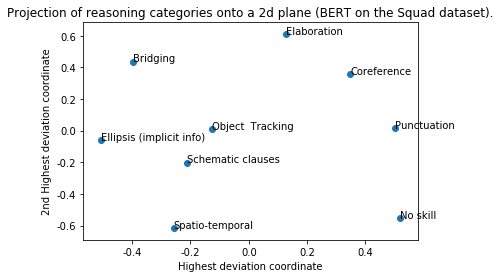

In [48]:
from scipy.sparse.csgraph import shortest_path

# dissimalrity = accuracy_table
#distanceMatrix = dissimalrity+0.5*np.eye(dissimalrity.shape[0], dissimalrity.shape[1])
# distanceMatrix = accuracy_table # - np.ones(distanceMatrix.shape)
pathDistance=shortest_path(separation_table)
print(pathDistance)

from sklearn.manifold import MDS
import matplotlib.pyplot as plt
mds=MDS(n_components=2,dissimilarity="precomputed", random_state=4)
emb=mds.fit_transform(pathDistance)
fig, ax = plt.subplots()
ax.scatter(emb[:,0],emb[:,1])
ax.set_xlabel("Highest deviation coordinate")
ax.set_ylabel("2nd Highest deviation coordinate")
for i, txt in enumerate(unique_types111):
    ax.annotate(txt, (emb[i,0],emb[i,1]))
plt.title('Projection of reasoning categories onto a 2d plane (BERT on the Squad dataset).')
plt.show()